**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.app.id,app-20231027030641-0990
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.driver.port,35409
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32


In [17]:
# Write your imports and code here or insert cells below

from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import
import matplotlib. pyplot as plt 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import explode, col
from pyspark.ml.recommendation import ALS
import numpy as np



In [5]:
# Data Processing
# Q1 (a)
# Reading the Datasets

# Define the base path for datasets
base_path = "hdfs:///data/msd/"

# List the directories and files under the base path
datasets = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).listStatus(spark._jvm.org.apache.hadoop.fs.Path(base_path))

# Extract dataset paths
dataset_paths = [item.getPath().toString() for item in datasets]

# Print the dataset paths
for path in dataset_paths:
    print(path)

hdfs://masternode2:9000/data/msd/audio
hdfs://masternode2:9000/data/msd/genre
hdfs://masternode2:9000/data/msd/main
hdfs://masternode2:9000/data/msd/tasteprofile


In [6]:

base_paths = dataset_paths

def list_files_recursive(path):
    """Recursively list all files under the given path."""
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(path))
    
    # Extract paths
    paths = [item.getPath().toString() for item in status]
    
    # Separate directories and files
    dirs = [p for p in paths if fs.isDirectory(spark._jvm.org.apache.hadoop.fs.Path(p))]
    files = [p for p in paths if fs.isFile(spark._jvm.org.apache.hadoop.fs.Path(p))]
    
    # Recursively explore directories
    for d in dirs:
        files.extend(list_files_recursive(d))
    
    return files

# Retrieve all dataset paths
all_dataset_paths = []
for base_path in base_paths:
    all_dataset_paths.extend(list_files_recursive(base_path))

# Print the dataset paths
for path in all_dataset_paths:
    print(path)

hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
hdfs://masternode2:9

In [7]:
# Group datasets by their base name to combine subsets
base_datasets = {}
for path in all_dataset_paths:
    base_name = path.split("/part-")[0]
    if base_name not in base_datasets:
        base_datasets[base_name] = []
    base_datasets[base_name].append(path)

def format_size(size, decimal_places=2):
    """Convert bytes to a readable format."""
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            break
        size /= 1024.0
    return f"{size:.{decimal_places}f} {unit}"

# Summarize each dataset
dataset_overviews = {}
for base_name, subsets in base_datasets.items():
    # Calculate total size
    total_size = sum([spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).getFileStatus(spark._jvm.org.apache.hadoop.fs.Path(subset)).getLen() for subset in subsets])
    
    
    # Read a subset, turning off header only for split datasets
    sample_df = spark.read.csv(subsets[0], header=False, inferSchema=True, sep=",")
    columns = sample_df.columns
    data_types = [str(field.dataType) for field in sample_df.schema.fields]
    
    dataset_overviews[base_name] = {
        "Size": format_size(total_size),
        "Columns": columns,
        "Data Types": data_types
    }

# Print the dataset overviews
for base_name, overview in dataset_overviews.items():
    print(f"Dataset: {base_name}")
    print(f"Size: {overview['Size']}")
    print(f"Columns: {overview['Columns']}")
    print(f"Data Types: {overview['Data Types']}")
    print("--------------------------------------------------")


Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
Size: 1.03 KB
Columns: ['_c0', '_c1']
Data Types: ['StringType', 'StringType']
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
Size: 671.00 B
Columns: ['_c0', '_c1']
Data Types: ['StringType', 'StringType']
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
Size: 484.00 B
Columns: ['_c0', '_c1']
Data Types: ['StringType', 'StringType']
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
Size: 898.00 B
Columns: ['_c0', '_c1']
Data Types: ['StringType', 'StringType']
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jm

In [8]:
# Q1(b)
# Count the number of rows in each dataset
dataset_counts = {}
for base_name, subsets in base_datasets.items():
    try:
        # Determine if the dataset is split into multiple .gz parts
        is_split = any("part-" in subset for subset in subsets)
        
        # Read the dataset, turning off header only for split datasets
        df = spark.read.csv(base_name, header=not is_split, inferSchema=True, sep=",")
        
        # Count the rows
        dataset_counts[base_name] = df.count()
    except Exception as e:
        print(f"Error reading dataset {base_name}: {str(e)}")
        continue

# Print the counts
for base_name, count in dataset_counts.items():
    print(f"Dataset: {base_name}")
    print(f"Number of Rows: {count}")
    print("--------------------------------------------------")



Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
Number of Rows: 20
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
Number of Rows: 20
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
Number of Rows: 10
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
Number of Rows: 26
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
Number of Rows: 16
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
Number of Rows: 

In [9]:
# Read the main dataset
main_dataset_path = "hdfs://masternode2:9000/data/msd/main/*/*.gz"
main_df = spark.read.csv(main_dataset_path, header=True, inferSchema=True, sep=",")

# Count unique songs
unique_songs_count = main_df.select("song_id").distinct().count()

print(f"Number of Unique Songs: {unique_songs_count}")
print("--------------------------------------------------")

# Compare with the counts from other datasets
for base_name, count in dataset_counts.items():
    print(f"Dataset: {base_name}")
    print(f"Number of Rows: {count}")
    print(f"Percentage of Total Unique Songs: {100 * count / unique_songs_count:.2f}%")
    print("--------------------------------------------------")


Number of Unique Songs: 998964
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
Number of Rows: 20
Percentage of Total Unique Songs: 0.00%
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
Number of Rows: 20
Percentage of Total Unique Songs: 0.00%
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
Number of Rows: 10
Percentage of Total Unique Songs: 0.00%
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
Number of Rows: 26
Percentage of Total Unique Songs: 0.00%
--------------------------------------------------
Dataset: hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmi

# Q1(a)

I guess this question need consider with:

1. **Impact on Analysis**: Mismatches between tracks in the Million Song Dataset and the Taste Profile dataset can lead to inaccurate analyses. For instance, if we're trying to correlate song features with user preferences, mismatches could skew the results.

2. **Datasets Used**: If our analysis involves both the Million Song Dataset and the Taste Profile dataset, then addressing mismatches becomes crucial. If we're only working with one of the datasets and not correlating data between them, the mismatches might not be relevant.

3. **Nature of Mismatches**: If there's a list of automatically identified mismatches and manually accepted mismatches, it's essential to understand the criteria used for both. The automatically identified mismatches might have been flagged based on some algorithmic criteria, while the manually accepted ones were likely reviewed by humans and deemed acceptable for some reason.

**Recommendation**:
If the analysis involves correlating data between the Million Song Dataset and the Taste Profile dataset, it's advisable to:
- Remove or correct the automatically identified mismatches.
- Review the manually accepted mismatches to understand why they were deemed acceptable and decide on a case-by-case basis.

However, if the analysis doesn't involve correlating data between these datasets, then addressing the mismatches might not be necessary.


In [17]:
# Q2(b)
# Do the type mapping
type_mapping = {
    "string": StringType(),
    "STRING": StringType(),
    "double": DoubleType(),
    "real": DoubleType(),
    "int": IntegerType(),
    "NUMERIC": DoubleType()
}

# Base paths
attribute_base_path = "hdfs://masternode2:9000/data/msd/audio/attributes/"
feature_base_path = "hdfs://masternode2:9000/data/msd/audio/features/"

# List all attribute files
attribute_files = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()).listStatus(spark._jvm.org.apache.hadoop.fs.Path(attribute_base_path))

# Dictionary to store DataFrames
dataframes = {}

for attribute_file in attribute_files:
    attribute_path = attribute_file.getPath().toString()
    prefix = attribute_path.split("/")[-1].replace(".attributes.csv", "")
    
    # Read the attribute file
    attribute_df = spark.read.csv(attribute_path, header=False, inferSchema=True, sep=",")
    
    # Extract attribute names and types
    attribute_data = attribute_df.collect()
    attribute_names = [row[0] for row in attribute_data]
    attribute_types = [row[1] for row in attribute_data]
    
    # Create the StructType schema
    schema = StructType([StructField(name, type_mapping[atype]) for name, atype in zip(attribute_names, attribute_types)])
    
    # Adjusted path for the feature dataset
    feature_dataset_path = f"{feature_base_path}{prefix}.csv/*.gz"
    df = spark.read.csv(feature_dataset_path, schema=schema, sep=",")
    
    # Save the DataFrame to the dictionary
    dataframes[prefix] = df
    
    # Display only one row of the data
    print(f"Dataset: {prefix}")
    df.show(n=1, truncate=False)  # Setting truncate to False to display full column content



Dataset: msd-jmir-area-of-moments-all-v1.0
+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------+
|A

In [20]:
# Audio Similarity
# Q1(a)

"""Dataset: hdfs://masternode2:9000/data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
I choose use this one, for the highest Percentage of Total Unique Songs: 99.60%."""
# Read the dataset
df = dataframes["msd-marsyas-timbral-v1.0"]

# Produce descriptive statistics
desc_stats = df.describe().show()




+-------+---------------------------------------------------------------------+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+-------------------------------------

In [22]:
# Correlations

# Sample the data (10% of the data) to save time
sampled_df = df.sample(False, 0.1)

# Convert to pandas DataFrame
pdf = sampled_df.toPandas()

# Compute the correlation matrix using pandas
correlation_matrix = pdf.corr()

# Identify strong correlations
correlations = []
for i, col1 in enumerate(correlation_matrix.columns):
    for j, col2 in enumerate(correlation_matrix.columns):
        if i < j and abs(correlation_matrix.at[col1, col2]) > 0.8:
            correlations.append((col1, col2, correlation_matrix.at[col1, col2]))

# Sort correlations in descending order based on the absolute value of correlation
correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)

# Display strong correlations
for col1, col2, corr_value in correlations:
    print(f"Correlation between {col1} and {col2}: {corr_value:.2f}")



Correlation between Mean_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0 and Std_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: 1.00
Correlation between Mean_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0 and Std_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: 1.00
Correlation between Mean_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0 and Std_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: 1.00
Correlation between Std_Acc5_Mean_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0 and Std_Acc5_Std_Mem20_PeakRatio_Minimum_Chroma_A_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0: 1.00
Correlation betwe

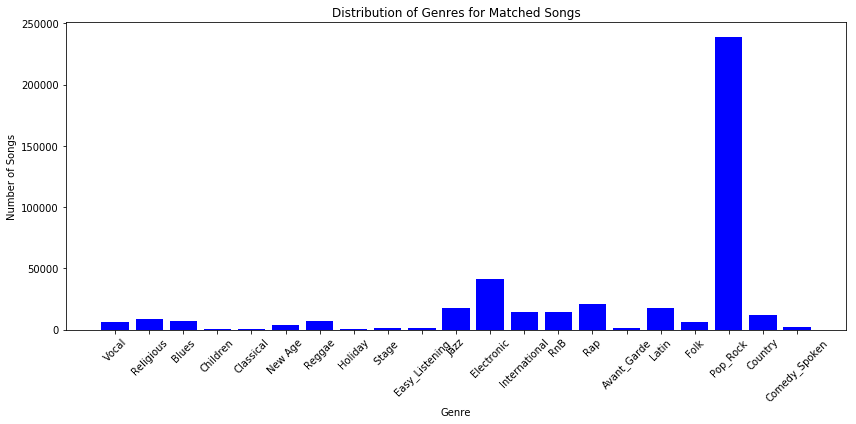

In [24]:
# Q1(b)

# Define the path for the MAGD dataset
magd_path = "hdfs://masternode2:9000/data/msd/genre/msd-MAGD-genreAssignment.tsv"

# Load the dataset
magd_df = spark.read.csv(magd_path, header=True, inferSchema=True, sep="\t")


# Rename the columns
magd_df = magd_df.withColumnRenamed("TRAAAAK128F9318786", "track_id").withColumnRenamed("Pop_Rock", "genre")

# Count the number of songs for each genre
genre_counts = magd_df.groupBy("genre").count().collect()

# Extract genre names and their counts
genres = [row['genre'] for row in genre_counts]
counts = [row['count'] for row in genre_counts]

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(genres, counts, color='blue')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Genres for Matched Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [25]:
# Q1(c)

# Extract the name of the last column in df
trackID_column = df.columns[-1]

# Rename the track_id column in magd_df to match the last column in df
magd_df = magd_df.withColumnRenamed("track_id", trackID_column)

# Ensure the trackID column in magd_df is correctly named
magd_df = magd_df.withColumnRenamed("trackID", trackID_column)

# Verify the column names of both dataframes
print("Columns in df:", df.columns)
print("Columns in magd_df:", magd_df.columns)

# Merge the datasets on the trackID
merged_df = df.join(magd_df, on=trackID_column, how="inner")

# Display the first few rows of the merged dataset to verify the merge
merged_df.show()





Columns in df: ['Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_Centroid_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_Rolloff_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_Flux_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC0_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC1_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC2_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC3_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC4_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC5_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0', 'Mean_Acc5_Mean_Mem20_MFCC6_Power_powerFFT_WinHamming_HopSize512_WinSize512_Sum_AudioCh0

Q2(a)

### 1. Choosing Three Classification Algorithms from the spark.ml library:

From the Spark ML library, the commonly used classification algorithms are:

1. **Logistic Regression**: It's a linear method for classification tasks. It's simple, interpretable, and works well for binary classification problems when the relationship between the features and the target variable is approximately linear.

2. **Random Forest Classifier**: This is an ensemble method that uses multiple decision trees to make predictions. It's robust, handles non-linear relationships well, and can handle a mix of numerical and categorical features.

3. **Gradient-Boosted Trees (GBTs)**: Another ensemble method that builds trees sequentially, where each tree tries to correct the mistakes of the previous one. It's powerful and often provides higher accuracy than other methods, but might be slower to train.

### 2. Justifying the Choice of Algorithms:

- **Logistic Regression**:
  - **Explainability & Interpretability**: High. Coefficients can be interpreted directly.
  - **Predictive Accuracy**: Good for linear relationships.
  - **Training Speed**: Fast.
  - **Hyperparameter Tuning**: Few hyperparameters like regularization strength.
  - **Dimensionality**: Can struggle with very high-dimensional data without regularization.
  - **Scaling Issues**: Sensitive to feature scaling.

- **Random Forest Classifier**:
  - **Explainability & Interpretability**: Medium. Feature importance can be derived, but individual trees might be complex.
  - **Predictive Accuracy**: High.
  - **Training Speed**: Fast with parallel processing.
  - **Hyperparameter Tuning**: More hyperparameters like number of trees, depth of trees, etc.
  - **Dimensionality**: Handles high-dimensional data well.
  - **Scaling Issues**: Not sensitive to feature scaling.

- **Gradient-Boosted Trees (GBTs)**:
  - **Explainability & Interpretability**: Medium. Like Random Forest, feature importance can be derived.
  - **Predictive Accuracy**: Very high.
  - **Training Speed**: Slower compared to Random Forest as trees are built sequentially.
  - **Hyperparameter Tuning**: Many hyperparameters like learning rate, number of trees, depth, etc.
  - **Dimensionality**: Handles high-dimensional data well.
  - **Scaling Issues**: Not sensitive to feature scaling.

### 3. Preprocessing Steps for the Audio Features:

Based on the descriptive statistics:

- **Scaling**: Many features have different scales (e.g., mean values ranging from 0.001 to 45.89). It's essential to scale the features, especially for algorithms like Logistic Regression. StandardScaler can be used to standardize features.

- **Handling Missing Values**: The count for some columns is less than 995001, indicating missing values. Depending on the number of missing values, we can either impute them using a strategy like mean imputation or remove those rows.

- **Dimensionality Reduction**: With a large number of features, dimensionality reduction techniques like PCA (Principal Component Analysis) can be considered, especially if computational efficiency is a concern.

- **Outlier Detection**: Some features might have outliers (e.g., max value of -143.14 for `_c4`). Depending on the domain knowledge and the impact of outliers on the model, one might consider techniques to handle outliers.



In [26]:
# Q2(b)

# Convert the genre column into a binary column
merged_df = merged_df.withColumn("is_electronic", (merged_df["genre"] == "Electronic").cast("int"))

# Count the number of rows for each class
electronic_count = merged_df.filter(merged_df["is_electronic"] == 1).count()
other_genre_count = merged_df.filter(merged_df["is_electronic"] == 0).count()

# Calculate the class balance
total_rows = merged_df.count()
electronic_percentage = (electronic_count / total_rows) * 100
other_genre_percentage = 100 - electronic_percentage

print(f"Percentage of Electronic songs: {electronic_percentage:.2f}%")
print(f"Percentage of Other genres: {other_genre_percentage:.2f}%")



Percentage of Electronic songs: 9.68%
Percentage of Other genres: 90.32%


In [56]:
# Q2(c)
# Define fractions for sampling
fractions = {
    1: 0.8,  # 80% for the "Electronic" class
    0: 0.8  # 80% for the "Other" class
}

# Create the training set
training_df = merged_df.sampleBy("is_electronic", fractions, seed=42)

# Create the test set
test_df = merged_df.subtract(training_df)


In [57]:
# Subsampling (Undersampling): This involves randomly removing some of the examples from the majority class. It's a good option when you have a large dataset, but you risk losing potentially important data.
# Count the number of rows for each class
electronic_count = training_df.filter(training_df["is_electronic"] == 1).count()
other_genre_count = training_df.filter(training_df["is_electronic"] == 0).count()

# Determine the minority class count
min_count = min(electronic_count, other_genre_count)

# Undersample the majority class
electronic_df = training_df.filter(training_df["is_electronic"] == 1).sample(withReplacement=False, fraction=min_count/electronic_count, seed=42)
other_genre_df = training_df.filter(training_df["is_electronic"] == 0).sample(withReplacement=False, fraction=min_count/other_genre_count, seed=42)

# Combine the datasets
undersampled_training_df = electronic_df.union(other_genre_df)


In [64]:
# Class balance for the test dataset
test_electronic_count = test_df.filter(test_df["is_electronic"] == 1).count()
test_other_genre_count = test_df.filter(test_df["is_electronic"] == 0).count()
test_total = test_df.count()

print(f"Test Dataset - Percentage of Electronic songs: {100 * test_electronic_count / test_total:.2f}%")
print(f"Test Dataset - Percentage of Other genres: {100 * test_other_genre_count / test_total:.2f}%")
print("--------------------------------------------------")

# Class balance for the undersampled training dataset
train_electronic_count = undersampled_training_df.filter(undersampled_training_df["is_electronic"] == 1).count()
train_other_genre_count = undersampled_training_df.filter(undersampled_training_df["is_electronic"] == 0).count()
train_total = undersampled_training_df.count()

print(f"Undersampled Training Dataset - Percentage of Electronic songs: {100 * train_electronic_count / train_total:.2f}%")
print(f"Undersampled Training Dataset - Percentage of Other genres: {100 * train_other_genre_count / train_total:.2f}%")


Test Dataset - Percentage of Electronic songs: 9.67%
Test Dataset - Percentage of Other genres: 90.33%
--------------------------------------------------
Undersampled Training Dataset - Percentage of Electronic songs: 50.18%
Undersampled Training Dataset - Percentage of Other genres: 49.82%


In [58]:
# Q2(d)
# Handle potential null values in track_id and Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0 columns
training_df = training_df.fillna({'track_id': 'UNKNOWN', 'Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0': 'UNKNOWN'})

# Convert track_id and Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0 to numeric indices
indexer1 = StringIndexer(inputCol="track_id", outputCol="track_id_indexed", handleInvalid="keep")
training_df = indexer1.fit(training_df).transform(training_df)

indexer2 = StringIndexer(inputCol="Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0", outputCol="Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0_indexed", handleInvalid="keep")
training_df = indexer2.fit(training_df).transform(training_df)

# Drop the original string columns
training_df = training_df.drop("track_id", "Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0")


# List of feature columns (excluding the target 'is_electronic', 'genre', and dropped columns)
feature_cols = [col for col in training_df.columns if col not in ['is_electronic', 'genre', 'track_id_indexed', 'Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0_indexed']]

# Initialize the VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the data
training_df = assembler.transform(training_df)



In [42]:

# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="is_electronic", maxIter=10)

# Train the model
lr_model = lr.fit(training_df)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [-0.9831776227368866,0.924832788544782,7.748498972247703,-0.021277740548477357,0.03298918535893932,0.06306609282757904,-0.30106748090762847,0.16191004175383664,0.006026630124351861,-0.06146382850877494,-0.020344572217913283,-0.0022484052549287515,-0.23043152852035692,-0.34382084522035167,-0.09255268316297681,-0.16807502660385407,-11.123174110723978,-18.202308731474396,-22.346441686579265,-10.505712151122307,-3.416532115389481,1.3595162921660222,5.9404348720531415,7.8946310659574666,10.551089242266467,9.695273187511985,4.983633251182423,-3.1322176475041292,-0.035591679229810255,8.070385820962003e-07,5.388414485879966,4.516847057472499,2.6946650195875907,5.413199871015684,0.18228069420473533,0.5277078117744611,0.5374704651519087,-0.1893865163254095,-0.2915081899472561,-0.35173229634860403,-0.7376613302372903,-0.9590534542141492,-0.9267932881621866,-1.0213687986569013,-0.8962724357023674,-0.9633512028180624,-1.191690437129315,10.81523226193329,7.169167317472936,9.63651708352

In [43]:

# Initialize the Random Forest model
rf = RandomForestClassifier(labelCol="is_electronic", numTrees=100)

# Train the model
rf_model = rf.fit(training_df)

# Print the feature importances
print("Feature Importances: " + str(rf_model.featureImportances))


Feature Importances: (123,[0,1,2,3,4,5,6,7,8,12,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,80,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122],[0.0008357411008092572,0.06759053514756845,0.06985918960164725,0.013646511270620384,0.0004948454278749203,0.0003054509183210576,0.024886595172613542,0.0017079619985607714,5.179971915523411e-06,0.0001404395870983484,2.409563917281778e-05,0.00034119417697759617,0.0001337920007160356,9.961120853037581e-05,0.00047132147790829006,5.731829811939388e-05,0.0007515048236034678,0.002348040257779703,0.0010782720149799107,0.0020084838549658287,0.0021065017995197575,0.001615710586926078,0.0009367949741496029,0.010022648610345726,0.002082162198873428,0.0521766578615322,0.011535518940921042,0.12851198591079388,0.02361

In [44]:

# Initialize the GBT model
gbt = GBTClassifier(labelCol="is_electronic", maxIter=10)

# Train the model
gbt_model = gbt.fit(training_df)

# Print the feature importances
print("Feature Importances: " + str(gbt_model.featureImportances))


Feature Importances: (123,[0,1,2,3,4,6,11,12,13,18,19,21,24,28,29,30,31,32,33,34,35,36,37,38,40,41,43,44,45,46,51,53,54,59,60,61,62,63,64,66,67,68,69,70,71,72,74,76,77,83,84,85,86,87,88,92,93,94,95,96,97,99,100,101,102,103,104,105,106,107,108,111,112,121],[0.0007353178641686615,0.0039059597735952322,0.016958048787700398,0.008083305266576793,0.008031448345026723,0.0794591457980089,0.00039598576821521167,0.0010072554774067913,0.0027133550562726135,0.0003179564021517641,0.004845517652300676,0.004677069051070184,0.006921711358547732,0.0005225265013994359,0.0008166584392997415,0.006619757790018138,0.0033259829998843605,0.1539192926796073,0.06361460206010833,0.006888429502311323,0.1067303042860589,0.000903945515296941,0.0009160493983327619,0.0009292475618899857,0.0004726365644445946,0.0086019846583667,0.046303738973137124,0.004321170919244272,0.000401074797910426,0.024391056223204064,0.007183817171606409,0.008699310534627056,0.006279869677919998,0.0035777755447015014,0.0011935980286116215,0.

In [53]:
# Q2(e)
indexer1_model = indexer1.fit(training_df)
indexer2_model = indexer2.fit(training_df)


# Handle potential null values in track_id and Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0 columns
test_df = test_df.fillna({'track_id': 'UNKNOWN', 'Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0': 'UNKNOWN'})

# Convert track_id and Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0 to numeric indices using the StringIndexerModels
test_df = indexer1_model.transform(test_df)
test_df = indexer2_model.transform(test_df)

# Drop the original string columns
test_df = test_df.drop("track_id", "Mean_Acc5_Mean_Mem20_ZeroCrossings_HopSize512_WinSize512_Sum_AudioCh0")

# Assemble the features
test_df = assembler.transform(test_df)


# Make predictions
lr_predictions = lr_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)
gbt_predictions = gbt_model.transform(test_df)


In [54]:

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="is_electronic")

# For Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})

# For Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})

# For Gradient-Boosted Trees
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedPrecision"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedRecall"})

# Print the metrics
print("Logistic Regression - Accuracy:", lr_accuracy)
print("Logistic Regression - Precision:", lr_precision)
print("Logistic Regression - Recall:", lr_recall)
print("--------------------------------------------------")
print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - Precision:", rf_precision)
print("Random Forest - Recall:", rf_recall)
print("--------------------------------------------------")
print("GBT - Accuracy:", gbt_accuracy)
print("GBT - Precision:", gbt_precision)
print("GBT - Recall:", gbt_recall)


Logistic Regression - Accuracy: 0.9148894849915642
Logistic Regression - Precision: 0.8992417344963065
Logistic Regression - Recall: 0.9148894849915642
--------------------------------------------------
Random Forest - Accuracy: 0.9100222122422227
Random Forest - Precision: 0.9013457536018108
Random Forest - Recall: 0.9100222122422227
--------------------------------------------------
GBT - Accuracy: 0.9177054632405598
GBT - Precision: 0.9036558149966164
GBT - Recall: 0.9177054632405598


# Q2(f)


1. **Accuracy**:
   - **GBT** has the highest accuracy at approximately 91.77%, followed closely by **Logistic Regression** at 91.49% and **Random Forest** at 91.00%. This means that GBT correctly predicted the genre (Electronic vs. Other) for about 91.77% of the songs in the test set, which is slightly better than the other two models.

2. **Precision**:
   - **Random Forest** has the highest precision at approximately 90.13%, followed by **GBT** at 90.37% and **Logistic Regression** at 89.92%. Precision measures the proportion of true positive predictions among all positive predictions. A higher precision indicates fewer false positives.

3. **Recall**:
   - The recall values are the same as the accuracy values for each model. Recall measures the proportion of actual positives that were correctly predicted. A higher recall indicates fewer false negatives.

**Discussion**:

- **GBT** appears to be the best-performing model overall, with the highest accuracy and recall and competitive precision. This is consistent with the general understanding that gradient-boosted trees often outperform other models, especially when the relationships between features and the target variable are complex.
  
- **Random Forest** and **Logistic Regression** also performed well, with Random Forest having a slight edge in precision. Random Forests are known for their robustness and ability to handle non-linear relationships, while Logistic Regression is a simpler linear model.

- The class balance of the binary label can significantly affect the performance of algorithms. If one class is much more frequent than the other (imbalanced dataset), models might become biased towards predicting the majority class, leading to high accuracy but poor recall for the minority class. In such cases, precision becomes a crucial metric as it can help identify the rate of false positives. 

- Given that the dataset was transformed to have a binary label (Electronic vs. Other), it's essential to consider both precision and recall. A model with high accuracy but low precision might be predicting most songs as "Other" (if it's the majority class), leading to many false positives for the "Electronic" genre.

- It's also worth noting that while accuracy is a useful metric, it might not always provide a complete picture, especially in imbalanced datasets. Precision, recall, and the F1 score (harmonic mean of precision and recall) are often more informative in such scenarios.



# Q3(a)

1. Logistic Regression:

maxIter: This is the maximum number of iterations for the optimization algorithm. If the algorithm converges before reaching maxIter, it will stop. Setting this too low might mean the algorithm doesn't converge; setting it too high might be computationally wasteful.
Other hyperparameters include regParam (regularization parameter), elasticNetParam (mixing parameter for L1 and L2 regularization), and threshold (threshold for binary classification prediction).
2. Random Forest Classifier:

numTrees: This is the number of trees in the forest. Increasing the number of trees will generally increase the model's performance but will also increase the computational cost.
maxDepth: The maximum depth of each tree. Deeper trees capture more complex patterns but are also more prone to overfitting.
featureSubsetStrategy: The number of features to consider for splits at each node. Common values are 'auto', 'sqrt', 'log2', etc.
Other hyperparameters include minInstancesPerNode (minimum number of instances required at a child node) and impurity (criterion used for information gain calculation).
3. Gradient-Boosted Trees (GBTs):

maxIter: This is the maximum number of iterations, which corresponds to the number of trees in boosting. More trees can capture more complex patterns but might also overfit.
maxDepth: The maximum depth of each tree.
stepSize: This is the learning rate. It determines the contribution of each tree to the final prediction. Lower values make the optimization more robust.
Other hyperparameters include minInstancesPerNode and lossType (loss function to be optimized).

# Q3(b)
**Cross-Validation**:

Cross-validation is a statistical technique used to estimate the performance of a machine learning model on unseen data. It involves partitioning the original training dataset into multiple subsets, training the model on some of these subsets, and validating the model on the remaining subsets. This process is repeated multiple times, and the model's performance is averaged over all iterations to provide a more robust estimate of its generalization capability.

**How Cross-Validation Works**:

1. **K-Fold Cross-Validation**: This is the most commonly used form of cross-validation.
   - The dataset is randomly partitioned into 'k' equal-sized folds or subsets.
   - The model is trained on 'k-1' of these folds and tested on the remaining fold.
   - This process is repeated 'k' times, each time using a different fold as the validation set and the remaining 'k-1' folds as the training set.
   - The results from all 'k' tests are averaged to produce a single performance metric.

2. **Stratified K-Fold Cross-Validation**: This is a variation of k-fold cross-validation that is used for imbalanced datasets. In this method, each fold is made by preserving the percentage of samples for each class, ensuring that each fold is representative of the overall class distribution.

3. **Leave-One-Out Cross-Validation (LOOCV)**: This is a special case of k-fold cross-validation where 'k' is equal to the number of observations in the dataset. In each iteration, a single observation is used as the validation set, and the remaining observations form the training set.

**Why Cross-Validation is Used for Hyperparameter Tuning**:

1. **Robust Performance Estimate**: By training and evaluating the model multiple times on different subsets of the data, cross-validation provides a more stable and reliable estimate of the model's performance.

2. **Reduced Overfitting**: Evaluating the model on different subsets of data helps in identifying if the model is overfitting to a specific subset of the data.

3. **Hyperparameter Selection**: When tuning hyperparameters, there's a risk of overfitting to the validation set because the model is being tweaked to perform best on that specific set. By using cross-validation, the hyperparameters are tested on multiple validation sets, reducing the risk of overfitting to any single subset of data.

4. **Better Utilization of Data**: Traditional train-test splits use a portion of data only for validation, which might not be ideal, especially if the dataset is small. Cross-validation ensures that every data point is used for both training and validation at some point, maximizing the information available for both training and evaluation.

In the context of hyperparameter tuning, cross-validation is typically combined with grid search or random search. For each combination of hyperparameters, the model's performance is evaluated using cross-validation, and the hyperparameters that give the best average performance across all folds are selected.

# Q3(c)
**Cross-Validation**:

Cross-validation is a statistical technique used to estimate the performance of a machine learning model on unseen data. It involves partitioning the original training dataset into multiple subsets, training the model on some of these subsets, and validating the model on the remaining subsets. This process is repeated multiple times, and the model's performance is averaged over all iterations to provide a more robust estimate of its generalization capability.

**How Cross-Validation Works**:

1. **K-Fold Cross-Validation**: This is the most commonly used form of cross-validation.
   - The dataset is randomly partitioned into 'k' equal-sized folds or subsets.
   - The model is trained on 'k-1' of these folds and tested on the remaining fold.
   - This process is repeated 'k' times, each time using a different fold as the validation set and the remaining 'k-1' folds as the training set.
   - The results from all 'k' tests are averaged to produce a single performance metric.

2. **Stratified K-Fold Cross-Validation**: This is a variation of k-fold cross-validation that is used for imbalanced datasets. In this method, each fold is made by preserving the percentage of samples for each class, ensuring that each fold is representative of the overall class distribution.

3. **Leave-One-Out Cross-Validation (LOOCV)**: This is a special case of k-fold cross-validation where 'k' is equal to the number of observations in the dataset. In each iteration, a single observation is used as the validation set, and the remaining observations form the training set.

**Why Cross-Validation is Used for Hyperparameter Tuning**:

1. **Robust Performance Estimate**: By training and evaluating the model multiple times on different subsets of the data, cross-validation provides a more stable and reliable estimate of the model's performance.

2. **Reduced Overfitting**: Evaluating the model on different subsets of data helps in identifying if the model is overfitting to a specific subset of the data.

3. **Hyperparameter Selection**: When tuning hyperparameters, there's a risk of overfitting to the validation set because the model is being tweaked to perform best on that specific set. By using cross-validation, the hyperparameters are tested on multiple validation sets, reducing the risk of overfitting to any single subset of data.

4. **Better Utilization of Data**: Traditional train-test splits use a portion of data only for validation, which might not be ideal, especially if the dataset is small. Cross-validation ensures that every data point is used for both training and validation at some point, maximizing the information available for both training and evaluation.

In the context of hyperparameter tuning, cross-validation is typically combined with grid search or random search. For each combination of hyperparameters, the model's performance is evaluated using cross-validation, and the hyperparameters that give the best average performance across all folds are selected.

# Q4(a)

I prefer the efficient one, Random Forest is a good choice. It's not only efficient but also handles multiclass problems naturally by using the majority voting system across its ensemble of decision trees.

How Random Forest Works for Multiclass Classification:

Training: During the training phase, each decision tree in the Random Forest is trained on a subset of the data. When a tree makes a decision, it assigns a class label to the input data.
Prediction: For a new input, each tree in the forest predicts a class label. The Random Forest then aggregates these predictions.
Majority Voting: The class label that gets the most votes (i.e., is predicted by the majority of the trees) is the final prediction of the Random Forest for that input.

Advantages:

Robustness: Random Forest is less prone to overfitting compared to individual decision trees because it averages out the biases by making its decision based on the majority vote.
Handles Imbalanced Data: Random Forest can handle class imbalance better than many other algorithms.
Feature Importance: Random Forest provides a measure of feature importance, which can be useful for interpretability.

In [59]:
# Drop the 'genre_label' column if it exists
if 'genre_label' in training_df.columns:
    training_df = training_df.drop('genre_label')

# Convert 'genre' column to numeric labels
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_label", handleInvalid="keep")
training_df = genre_indexer.fit(training_df).transform(training_df)

# Initialize the Random Forest model for multiclass classification
rf_multi = RandomForestClassifier(labelCol="genre_label", numTrees=100)

# Train the model
rf_multi_model = rf_multi.fit(training_df)

# Print the feature importances
print("Feature Importances: " + str(rf_multi_model.featureImportances))


Feature Importances: (123,[0,1,2,3,4,5,6,9,10,12,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,112,113,114,115,116,117,118,119,122],[0.0009509363201889977,0.005578786106628571,0.011390853282831884,0.060700141860509566,0.0008599049913157538,0.0005543189000457291,0.0015045477242848636,0.0002969595634215369,7.434869328894452e-05,0.0006282330953704964,0.0002618468121700084,0.0015355401201821725,0.00031613754854793995,0.0009673406202046054,0.0006803745943319334,0.0008087283813028884,0.000653808011064372,0.0011121441138765525,0.0022482433563229746,0.00014852568098394612,0.0008863820177356458,0.00015589463864307962,0.004398568364568281,0.01687964170784638,0.005612808029681664,0.0875055938774913,0.007966269444250124,0.11976632642587116,0.06400836938393042,0.

# Q4(b)
To convert the genre column into an integer index can use the StringIndexer from PySpark's ml.feature module. The StringIndexer will automatically assign a unique integer to each distinct genre in the genre column, which makes it a great tool for this task as it requires minimal manual work.

In [60]:

# Initialize the StringIndexer
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index", handleInvalid="keep")

# Fit the StringIndexer model and transform the DataFrame
indexed_df = genre_indexer.fit(training_df).transform(training_df)

# Show the first few rows to verify
indexed_df.select("genre", "genre_index").distinct().show()


+--------------+-----------+
|         genre|genre_index|
+--------------+-----------+
|           Rap|        2.0|
|   Avant_Garde|       17.0|
|    Electronic|        1.0|
| International|        5.0|
|      Pop_Rock|        0.0|
|        Stage |       15.0|
|         Blues|       10.0|
|          Jazz|        3.0|
|       New Age|       13.0|
|      Children|       19.0|
|          Folk|       12.0|
|     Classical|       18.0|
|     Religious|        8.0|
|         Latin|        4.0|
|        Reggae|        9.0|
|Easy_Listening|       16.0|
|         Vocal|       11.0|
| Comedy_Spoken|       14.0|
|       Holiday|       20.0|
|           RnB|        6.0|
+--------------+-----------+
only showing top 20 rows



In [61]:
# Q4(c)
# Split the data into training and test sets (70% training, 30% test)
train_data, test_data = indexed_df.randomSplit([0.7, 0.3], seed=42)


In [62]:

# Initialize the Random Forest model for multiclass classification
rf_multi = RandomForestClassifier(labelCol="genre_index", numTrees=100)

# Train the model
rf_multi_model = rf_multi.fit(train_data)


In [63]:

# Make predictions on the test set
predictions = rf_multi_model.transform(test_data)

# Initialize evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="f1")

# Compute metrics
accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.5943973286841405
F1 Score: 0.46734772375449213


# Song recommendations

## Q1(a)


1. **Size**: If the Taste Profile dataset is large, repartitioning can help distribute the data more evenly across the cluster's nodes, ensuring that each node processes roughly the same amount of data. This can lead to better parallelism and faster processing times.

2. **Format**: If the dataset is stored in a format that is not optimized for Spark (e.g., plain CSV), converting it to a more efficient format like Parquet can speed up read/write operations. Parquet is a columnar storage format that is optimized for the kinds of large-scale queries that Spark runs.

3. **Number of Rows**: A high number of rows might mean that the dataset is large, but not necessarily. If there are many rows but few columns, the dataset might still fit comfortably in memory. However, if both the number of rows and columns are high, caching can help. When you cache a dataset in Spark, it's stored in memory, making subsequent operations on that dataset faster.

4. **Collaborative Filtering**: Collaborative filtering algorithms, especially matrix factorization methods like Alternating Least Squares (ALS) used in Spark, involve iterative computations. Iterative algorithms benefit from caching because they repeatedly access the same data. By caching the dataset, you avoid reading it from disk on each iteration.

**Recommendation**:

Given the iterative nature of collaborative filtering algorithms and assuming the Taste Profile dataset is large, it would be beneficial to:

- **Repartition** the dataset to ensure data is evenly distributed across the cluster's nodes.
- **Cache** the dataset in memory to speed up iterative computations.


In [4]:
#Q1(b)
# Path to the Taste Profile dataset
taste_profile_path = "hdfs://masternode2:9000/data/msd/tasteprofile/*/*.gz"

# Read the Taste Profile dataset with tab delimiter
taste_profile_df = spark.read.csv(taste_profile_path, header=False, inferSchema=True, sep="\t")

# According to the description and double_check the content, the _c0 is user column and the _c1 is song column.

# Count unique songs
unique_songs_count = taste_profile_df.select("_c1").distinct().count()

# Count unique users
unique_users_count = taste_profile_df.select("_c0").distinct().count()

print(f"Number of Unique Songs: {unique_songs_count}")
print(f"Number of Unique Users: {unique_users_count}")


Number of Unique Songs: 384546
Number of Unique Users: 1019318


In [5]:
# Q1(c)

# Identify the most active user
most_active_user = taste_profile_df.groupBy("_c0").count().orderBy("count", ascending=False).first()[0]

# Count how many different songs the most active user has played
songs_played_by_most_active_user = taste_profile_df.filter(taste_profile_df._c0 == most_active_user).select("_c1").distinct().count()

print(f"Number of Different Songs Played by Most Active User: {songs_played_by_most_active_user}")

# Calculate this as a percentage of the total number of unique songs
percentage_of_total_songs = (songs_played_by_most_active_user / unique_songs_count) * 100

print(f"This is {percentage_of_total_songs:.2f}% of the total number of unique songs in the dataset.")


Number of Different Songs Played by Most Active User: 4400
This is 1.14% of the total number of unique songs in the dataset.


In [12]:
# Q1(d)

# Count the number of plays for each song
song_popularity = taste_profile_df.groupBy("_c1").count().withColumnRenamed("count", "plays_per_song")

# Count the number of songs played by each user
user_activity = taste_profile_df.groupBy("_c0").count().withColumnRenamed("count", "songs_per_user")


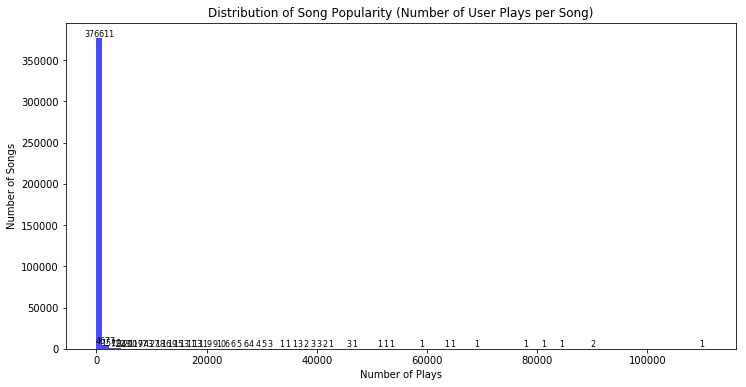

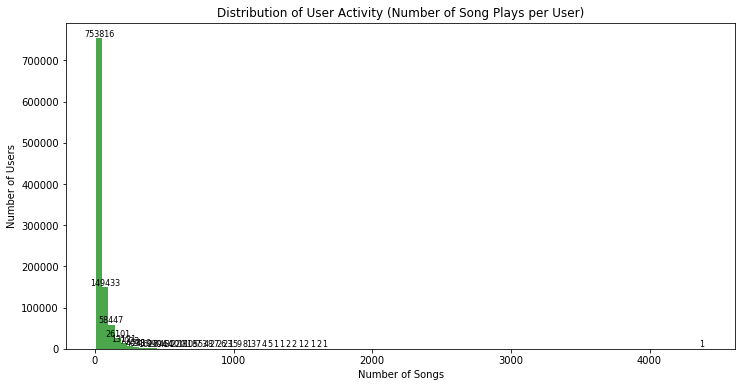

In [18]:

def annotate_histogram(ax, bins, data):
    """Annotate histogram with non-overlapping labels."""
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(data, bin_centers):
        # Check if the count is non-zero
        if count:
            y = count
            # Format the count as an integer
            label = str(int(count))
            ax.text(x, y, label, ha='center', va='bottom', fontsize=8)

# Plot distribution of song popularity
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(song_popularity_data, bins=100, color='blue', alpha=0.7)
annotate_histogram(plt.gca(), bins, counts)
plt.title("Distribution of Song Popularity (Number of User Plays per Song)")
plt.xlabel("Number of Plays")
plt.ylabel("Number of Songs")
plt.show()

# Plot distribution of user activity
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(user_activity_data, bins=100, color='green', alpha=0.7)
annotate_histogram(plt.gca(), bins, counts)
plt.title("Distribution of User Activity (Number of Song Plays per User)")
plt.xlabel("Number of Songs")
plt.ylabel("Number of Users")
plt.show()


In [ ]:
# Q2(a)
# Count the number of times each song has been played
song_play_counts = taste_profile_df.groupBy("_c1").count().withColumnRenamed("count", "plays_per_song")

# Count the number of songs each user has listened to
user_play_counts = taste_profile_df.groupBy("_c0").count().withColumnRenamed("count", "songs_per_user")


In [9]:
# Determine the 25th percentile for song plays and user activity
N = song_play_counts.approxQuantile("plays_per_song", [0.25], 0)[0]
M = user_play_counts.approxQuantile("songs_per_user", [0.25], 0)[0]


In [15]:
# Filter songs with more than N plays
filtered_songs = song_play_counts.filter(song_play_counts.plays_per_song >= N).select("_c1")

# Filter users who have listened to more than M songs
filtered_users = user_play_counts.filter(user_play_counts.songs_per_user >= M).select("_c0")

# Join the original dataset with the filtered songs and users
clean_dataset = taste_profile_df.join(filtered_songs, on="_c1").join(filtered_users, on="_c0")

clean_dataset.count()

45211953

In [30]:
# Q2(b)


prelim_train, prelim_test = clean_dataset.randomSplit([0.75, 0.25], seed=42)

train_users = prelim_train.select("_c0").distinct()
test_users = prelim_test.select("_c0").distinct()

# Find users in test set that are not in training set
users_not_in_train = test_users.subtract(train_users)
# Extract rows for these users from the test set
rows_to_move = prelim_test.join(users_not_in_train, on="_c0")

# Remove these rows from the test set and add them to the training set
prelim_test = prelim_test.subtract(rows_to_move)
final_train = prelim_train.union(rows_to_move)



In [17]:
def check_users_in_train_test(train_df, test_df):
    """
    Check if every user in the test set also appears in the training set.
    
    Parameters:
    - train_df: DataFrame of the training set
    - test_df: DataFrame of the test set
    
    Returns:
    - True if the condition is met, False otherwise
    """
    train_users = train_df.select("_c0").distinct()
    test_users = test_df.select("_c0").distinct()

    # Find users in test set that are not in training set
    users_not_in_train = test_users.subtract(train_users)

    # If there are no users in this set, return True, else return False
    return users_not_in_train.count() == 0

# Use the function to check the datasets
is_valid_split = check_users_in_train_test(final_train, prelim_test)
if is_valid_split:
    print("All users in the test set also appear in the training set!")
else:
    print("Warning: Some users in the test set do not appear in the training set!")


All users in the test set also appear in the training set!


The reason for ensuring every user in the test set also appears in the training set is due to the nature of collaborative filtering.
Collaborative filtering models, like the Alternating Least Squares (ALS) algorithm in Spark, work by learning latent factors for both users and items (in this case, songs) based on historical interactions. 
When making predictions or recommendations for a user, the model uses the learned latent factors for that user. 
If a user in the test set doesn't have any interactions in the training set, the model won't have learned any latent factors for them, making it impossible to generate meaningful predictions or recommendation.

By following the above steps, we ensure that the split between training and test sets is as random as possible while still meeting the requirement that all users in the test set also appear in the training set.



In [26]:
# Q2(c)
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

# Indexing user and song IDs
user_indexer = StringIndexer(inputCol="_c0", outputCol="userIndex")
song_indexer = StringIndexer(inputCol="_c1", outputCol="songIndex")

# Fit and transform the data
indexed_data = user_indexer.fit(final_train).transform(final_train)
indexed_data = song_indexer.fit(indexed_data).transform(indexed_data)



In [19]:
# Initialize the ALS model
als = ALS(
    userCol="userIndex",
    itemCol="songIndex",
    ratingCol="_c2",
    implicitPrefs=True,
    coldStartStrategy="drop"
)

# Fit the model to the training data
model = als.fit(indexed_data)


In [38]:
# Q2(d)
# Select a few users from the test set
sample_users = prelim_test.select("userIndex").distinct().limit(5).collect()
sample_user_indices = [row.userIndex for row in sample_users]




In [41]:
# Generate recommendations for the selected users
num_recommendations = 10
recommendations = model.recommendForAllUsers(num_recommendations).filter(col("userIndex").isin(sample_user_indices))



In [44]:
from pyspark.sql.functions import explode, col

# Explode the recommendations column to get song indices
recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")) \
    .select("userIndex", col("rec_exp.songIndex"), col("rec_exp.rating"))

# Join with the indexed_data to get song IDs
recs_with_song_ids = recs_exploded.join(indexed_data, on=["songIndex", "userIndex"], how="left").select("userIndex", "_c1").distinct()


In [45]:
for user in sample_user_indices:
    # Songs the user has actually played
    actual_songs = prelim_test.filter(prelim_test.userIndex == user).select("_c1").collect()
    actual_song_ids = [row._c1 for row in actual_songs]
    
    # Songs recommended to the user
    recommended_songs = recs_with_song_ids.filter(recs_with_song_ids.userIndex == user).select("_c1").collect()
    recommended_song_ids = [row._c1 for row in recommended_songs]
    
    print(f"User {user}:")
    print("Actual Songs Played:")
    print(actual_song_ids)
    print("Recommended Songs:")
    print(recommended_song_ids)
    print("--------------------------------------------------")


User 277544.0:
Actual Songs Played:
['SOQFXDQ12AF72AD0EE', 'SOFXWBG12A6D4F74BE', 'SOALROV12A6D4F91F9', 'SONVRTN12A8C1385C2', 'SOXTBGF12A6D4FB49C', 'SOAOAHZ12A8C13AAF1', 'SOYQPNY12A6BD4D3C2', 'SOJYWLL12AB018A7AD', 'SOFQFWN12A58A7A84E', 'SOGHYFM12A6702162A', 'SOWSPUS12AC468BEE3', 'SOZLKKS12AB018B2D7', 'SONNSYV12A8C146BEC', 'SOQICOL12A67020211', 'SOKUMPJ12A8C1418B6', 'SOAKMDU12A8C1346A9', 'SOKLRPJ12A8C13C3FE']
Recommended Songs:
['SOUFTBI12AB0183F65', None, 'SOFLJQZ12A6D4FADA6']
--------------------------------------------------
User 577901.0:
Actual Songs Played:
['SORVQZE12A58A7AE98', 'SOULLOA12A6701FC56', 'SOOUAIU12AB0182EF5', 'SOUHTDV12A6D4FA447', 'SOBDASI12A8C13E814']
Recommended Songs:
[None, 'SOLFXKT12AB017E3E0']
--------------------------------------------------
User 241690.0:
Actual Songs Played:
['SOAUWYT12A81C206F1', 'SOGMGBJ12A8AE48305', 'SOSVPIE12A6D4FA873', 'SOCVTLJ12A6310F0FD', 'SOKYVWL12A67AE0922', 'SOVHPUT12A81C22A56', 'SOWOMMY127F8096DF9', 'SOMBNTT12AB01854AE', 'SOGQNYF1

In [48]:
# Q2(f)
def precision_at_k(recommended, actual, k=10):
    """Compute Precision @ k."""
    rec_k = recommended[:k]
    relevant_and_recommended = len(set(rec_k) & set(actual))
    return relevant_and_recommended / k

def ndcg_at_k(recommended, actual, k=10):
    """Compute NDCG @ k."""
    dcg = 0
    idcg = sum([1.0 / (i + 1) for i in range(min(len(actual), k))])
    for i, rec in enumerate(recommended[:k]):
        if rec in actual:
            dcg += 1.0 / (i + 1)
    return dcg / idcg

def average_precision(recommended, actual):
    """Compute Average Precision."""
    hits = 0
    sum_precs = 0
    for i, rec in enumerate(recommended):
        if rec in actual:
            hits += 1
            sum_precs += hits / (i + 1)
    return sum_precs / len(actual)



In [50]:
precisions = []
ndcgs = []
maps = []

user_actual_songs = {
    277544.0: ['SOQGDUZ12A58A7F686', 'SONGFYO12A6D4F678E', 'SOWWVQC12A6D4F86D5', 'SOEWRGJ12AB017F7E5', 'SOLBKGD12A6D4F5CF0', 'SOARPHS12A6D4FB4C4', 'SOFSBMX12A6D4F9CA0', 'SOKZZCE12AB0186073', 'SOJNHOP12A6D4F778D', 'SOCHKFO12AB01860DB', 'SOZQVQL12AB01860A8'],
    577901.0: ['SORVQZE12A58A7AE98', 'SOULLOA12A6701FC56', 'SOOUAIU12AB0182EF5', 'SOUHTDV12A6D4FA447', 'SOBDASI12A8C13E814'],
    241690.0: ['SOAUWYT12A81C206F1', 'SOGMGBJ12A8AE48305', 'SOSVPIE12A6D4FA873', 'SOCVTLJ12A6310F0FD', 'SOKYVWL12A67AE0922', 'SOVHPUT12A81C22A56', 'SOWOMMY127F8096DF9', 'SOMBNTT12AB01854AE', 'SOGQNYF12AB0185865', 'SODLMAC12A8C141D96', 'SOKLRPJ12A8C13C3FE', 'SOMGIYR12AB0187973'],
    405503.0: ['SOECDQZ12A58A784BA', 'SOWRCYH12A58A7C559', 'SORTVKN12A81C20B9F', 'SOZIBZP12A6701C434'],
    664751.0: ['SOQFXDQ12AF72AD0EE', 'SOFXWBG12A6D4FB49C', 'SOALROV12A6D4F91F9', 'SONVRTN12A8C1385C2', 'SOXTBGF12A6D4FB49C', 'SOAOAHZ12A8C13AAF1', 'SOYQPNY12A6BD4D3C2', 'SOJYWLL12AB018A7AD', 'SOFQFWN12A58A7A84E', 'SOGHYFM12A6702162A', 'SOWSPUS12AC468BEE3', 'SOZLKKS12AB018B2D7', 'SONNSYV12A8C146BEC', 'SOQICOL12A67020211', 'SOKUMPJ12A8C1418B6', 'SOAKMDU12A8C1346A9', 'SOKLRPJ12A8C13C3FE']
}

user_recommended_songs = {
    277544.0: ['SOUFTBI12AB0183F65', None, 'SOFLJQZ12A6D4FADA6'],
    577901.0: [None, 'SOLFXKT12AB017E3E0'],
    241690.0: [None, 'SOBONKR12A58A7A7E0', 'SOTVLQY12A58A798C2', 'SOFRQTD12A81C233C0'],
    405503.0: [None],
    664751.0: [None, 'SONNSYV12A8C146BEC']
}


for user in [277544.0, 577901.0, 241690.0, 405503.0, 664751.0]:
    actual = [song for song in user_actual_songs[user] if song is not None]
    recommended = [song for song in user_recommended_songs[user] if song is not None]
    
    precisions.append(precision_at_k(recommended, actual))
    ndcgs.append(ndcg_at_k(recommended, actual))
    maps.append(average_precision(recommended, actual))

# Average the metrics
mean_precision = sum(precisions) / len(precisions)
mean_ndcg = sum(ndcgs) / len(ndcgs)
mean_map = sum(maps) / len(maps)

print(f"Mean Precision @ 10: {mean_precision}")
print(f"Mean NDCG @ 10: {mean_ndcg}")
print(f"Mean Average Precision: {mean_map}")


Mean Precision @ 10: 0.02
Mean NDCG @ 10: 0.06828343042948111
Mean Average Precision: 0.011764705882352941


In [19]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()